# [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic)

## EDA 분석 결과

- Target
  - 이진분류 문제
  - 비율은 5:5 정도임(balanced data)
- Missing Values가 많음
- Continuous
  - Age: 나이대별로 도착 확률이 다름
  - luxury: RoomService, Spa, VRDeck
    - False 데이터인 분들의 소비가 더 높음
  - essential: FoodCourt, ShoppingMall
    - True 데이터인 분들의 소비가 더 높음
- Categorical
  - VIP: 필요없는 데이터임(삭제 필요)
  - CryoSleep: 유용한 데이터일 확률이 높음
  - HomePlanet
  - Destination
- Qualitative
  - PassengerId: group number + people number of group
  - Cabin: deck + number + side
  - Name: first name + last name(성)

## Data

- PassengerId - 각 승객에 대한 고유 ID
  - gggg_pp: gggg는 group, pp는 group에 소속된 사람 수
  - 같은 group에 속한 사람들은 가족일 수도 있고, 아닐 수도 있음
- HomePlanet - 출발 행성(거주지)
- CryoSleep - 취침 방식 여부
- Cabin - 객실 종류 및 번호(port:좌현, starboard: 우현)
- Destination - 목적지
- Age - 승객의 나이
- VIP - 승객의 VIP 서비스 유무
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 승객이 해당 서비스에 대한 지불한 금액
- Name - 이름
  - 같은 그룹이면서, 성이 같으면 ?? 가족일 확률이 높음
- Transported - 도착여부

# Import Library

In [2]:
!pip install shap
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [3]:
import os
import datetime

# 데이터 분석
import numpy as np
import pandas as pd
from scipy import stats

# 데이터 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

# 데이터 분리
from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance
import shap

# model
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# warning
import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Global Variables

In [4]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [5]:
import easydict
import json
args = easydict.EasyDict()

# path
args.default_path = '/content/data/MyDrive/google_lecture/05. machine learning/Projects/kaggle/spaceship_titanic/data/'
args.train_path = args.default_path+'train.csv'
args.test_path = args.default_path+'test.csv'
args.submission_path = args.default_path+'sampleSubmission.csv'

args.SEED = 42

# Load Data

In [6]:
ori_train = pd.read_csv(args.train_path)

print(ori_train.shape)
ori_train.head(3)

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [7]:
ori_test = pd.read_csv(args.test_path)

print(ori_test.shape)

(4277, 13)


# Data Preprocessing

In [35]:
pre_train = ori_train.copy()
pre_test = ori_test.copy()

pre_train.shape, pre_test.shape

((8693, 14), (4277, 13))

## Age

Text(0.5, 0, 'Age (years)')

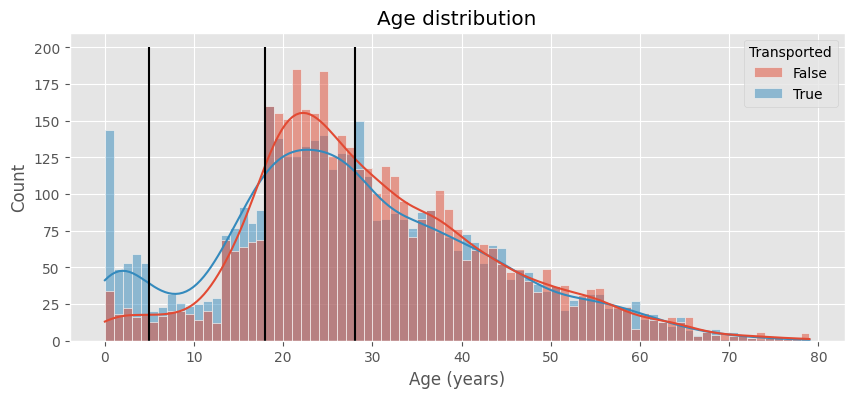

In [36]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=pre_train, x='Age', hue='Transported', binwidth=1, kde=True)

plt.vlines(5, ymin=0, ymax=200, color='black')
plt.vlines(18, ymin=0, ymax=200, color='black')
plt.vlines(28, ymin=0, ymax=200, color='black')

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

- age <= 4
  - True가 압도적으로 많음

In [19]:
pre_train[pre_train['Age'] == 4]['Transported'].value_counts()

True     53
False    18
Name: Transported, dtype: int64

In [20]:
pre_train[pre_train['Age'] == 5 ]['Transported'].value_counts()

True     20
False    13
Name: Transported, dtype: int64

- age <= 17 & age >= 5
  - True가 더 많음

In [21]:
pre_train[pre_train['Age'] == 17 ]['Transported'].value_counts()

True     89
False    69
Name: Transported, dtype: int64

In [22]:
pre_train[pre_train['Age'] == 18 ]['Transported'].value_counts()

True     160
False    160
Name: Transported, dtype: int64

- age <=27 & age >=18
  - False가 더 많음

In [24]:
pre_train[pre_train['Age'] == 27 ]['Transported'].value_counts()

False    132
True     127
Name: Transported, dtype: int64

In [23]:
pre_train[pre_train['Age'] == 28 ]['Transported'].value_counts()

True     150
False    117
Name: Transported, dtype: int64

In [37]:
def add_age_group(age):
    if age <= 4:
      return 'age_4'
    elif age <= 17:
      return 'age_17'
    elif age <= 27:
      return 'age_27'
    else:
      return 'age_28+'

In [38]:
pre_train['age_group'] = pre_train['Age'].map(add_age_group)
pre_test['age_group'] = pre_test['Age'].map(add_age_group)

pre_train[['Age', 'age_group']].head(3)

,Age,age_group
0,39.0,age_28+
1,24.0,age_27
2,58.0,age_28+


In [39]:
pre_train['log_age'] = pre_train['Age'].map(lambda x: np.log1p(x))
pre_test['log_age'] = pre_test['Age'].map(lambda x: np.log1p(x))

pre_train[['Age', 'log_age']].head(3)

,Age,log_age
0,39.0,3.688879
1,24.0,3.218876
2,58.0,4.077537


Text(0.5, 0, 'Age (years)')

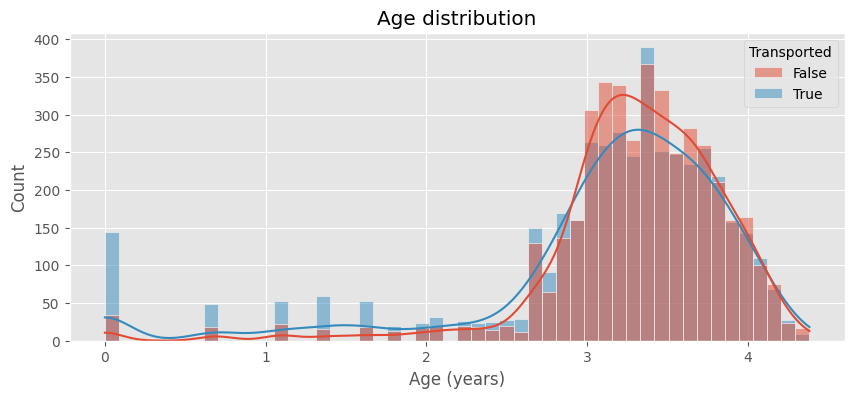

In [33]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=pre_train, x='log_age', hue='Transported', bins=50, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

## luxury
- RoomService, Spa, VRDeck

In [40]:
# New features - training set
luxury_cols = ['RoomService', 'Spa', 'VRDeck']
pre_train['luxury_sum']=pre_train[luxury_cols].sum(axis=1)
pre_train['luxury_no']=(pre_train['luxury_sum']==0).astype(int)

pre_test['luxury_sum']=pre_test[luxury_cols].sum(axis=1)
pre_test['luxury_no']=(pre_test['luxury_sum']==0).astype(int)

pre_train[['RoomService', 'Spa', 'VRDeck', 'luxury_sum', 'luxury_no']].head()

,RoomService,Spa,VRDeck,luxury_sum,luxury_no
0,0.0,0.0,0.0,0.0,1
1,109.0,549.0,44.0,702.0,0
2,43.0,6715.0,49.0,6807.0,0
3,0.0,3329.0,193.0,3522.0,0
4,303.0,565.0,2.0,870.0,0


In [41]:
pre_train['log_luxury'] = pre_train['luxury_sum'].map(lambda x: np.log1p(x))
pre_test['log_luxury'] = pre_test['luxury_sum'].map(lambda x: np.log1p(x))

pre_train[['luxury_sum', 'log_luxury']].head(3)

,luxury_sum,log_luxury
0,0.0,0.000000
1,702.0,6.555357
2,6807.0,8.825854


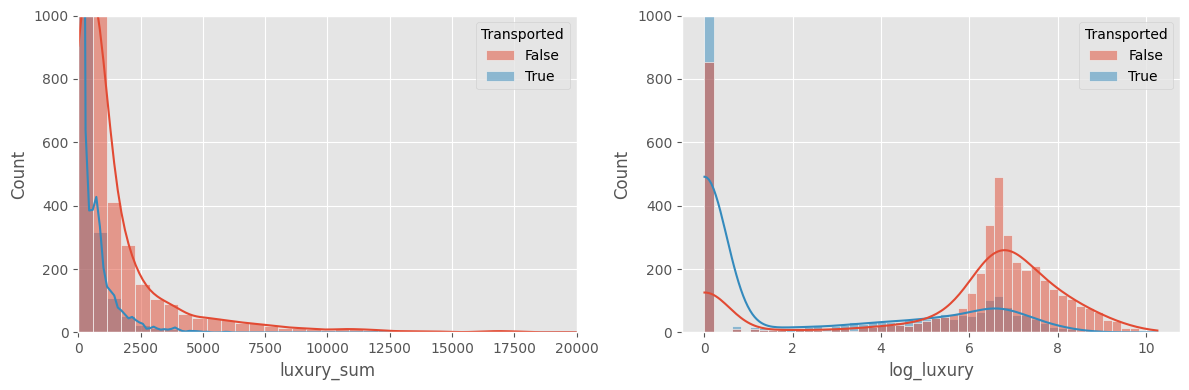

In [43]:
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=pre_train, x='luxury_sum', hue='Transported', bins=50, kde=True)
plt.ylim([0,1000])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.histplot(data=pre_train, x='log_luxury', hue='Transported', bins=50, kde=True)
plt.ylim([0,1000])
fig.tight_layout()

## Esemtoa
  - FoodCourt, ShoppingMall

In [44]:
# New features - training set
essential_cols = ['FoodCourt', 'ShoppingMall']
pre_train['essential_sum']=pre_train[essential_cols].sum(axis=1)
pre_train['enssential_no']=(pre_train['essential_sum']==0).astype(int)

pre_test['essential_sum']=pre_test[essential_cols].sum(axis=1)
pre_test['enssential_no']=(pre_test['essential_sum']==0).astype(int)

pre_train[['FoodCourt', 'ShoppingMall', 'essential_sum', 'enssential_no']].head()

,FoodCourt,ShoppingMall,essential_sum,enssential_no
0,0.0,0.0,0.0,1
1,9.0,25.0,34.0,0
2,3576.0,0.0,3576.0,0
3,1283.0,371.0,1654.0,0
4,70.0,151.0,221.0,0


In [45]:
pre_train['log_essential'] = pre_train['essential_sum'].map(lambda x: np.log1p(x))
pre_test['log_essential'] = pre_test['essential_sum'].map(lambda x: np.log1p(x))

pre_train[['essential_sum', 'log_essential']].head(3)

,essential_sum,log_essential
0,0.0,0.000000
1,34.0,3.555348
2,3576.0,8.182280


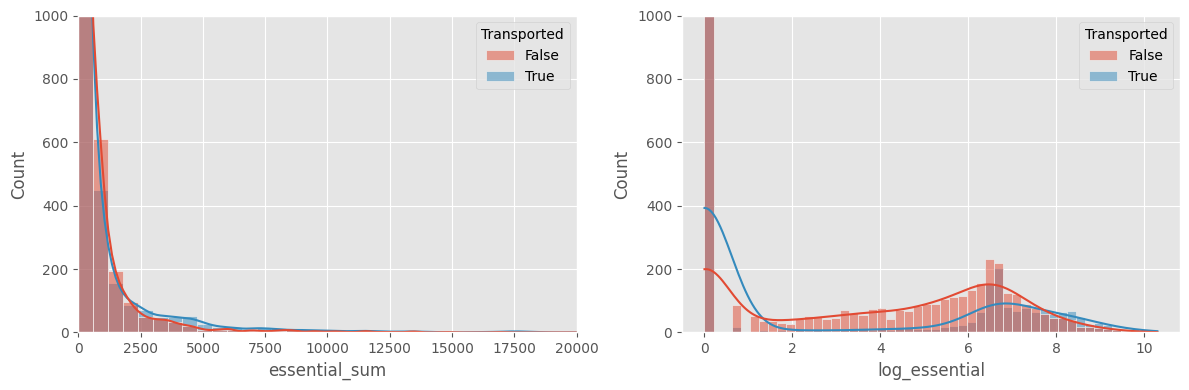

In [46]:
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=pre_train, x='essential_sum', hue='Transported', bins=50, kde=True)
plt.ylim([0,1000])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.histplot(data=pre_train, x='log_essential', hue='Transported', bins=50, kde=True)
plt.ylim([0,1000])
fig.tight_layout()

# Base Model

In [ ]:
print(f'before: {pre_train.shape} / {pre_test.shape}')

train = pre_train.copy()
test = pre_test.copy()

print(f"after: {train.shape} / {test.shape}")
train.head(2)

## Split data

## Model